In [1]:
import pandas as pd
import pprint as pp
import networkx as nx
import pickle
from operator import itemgetter, attrgetter

In [2]:
data_dir = './data/'

In [98]:
# Data
is_medium = True
get_empty = True
file_pre = 'medium' if is_medium else 'large'
empty_str = '_60percent_of_empty_profile'

graph = nx.read_gexf(data_dir + file_pre + 'Linkedin.gexf')
location = pd.read_pickle(data_dir + file_pre + 'Location.pickle')
employer = pd.read_pickle(data_dir + file_pre + 'Employer.pickle')
college = pd.read_pickle(data_dir + file_pre + 'College.pickle')

location_empty = pd.read_pickle(data_dir + file_pre + 'Location' + (empty_str if get_empty else '') + '.pickle')
employer_empty = pd.read_pickle(data_dir + file_pre + 'Employer' + (empty_str if get_empty else '') + '.pickle')
college_empty = pd.read_pickle(data_dir + file_pre + 'College' + (empty_str if get_empty else '') + '.pickle')
nodes_taken_out = pd.read_pickle(data_dir + file_pre + 'RemovedNodes_60percent_of_empty_profile.pickle')

In [4]:
# Add attributes to nodes in graph
possible_attributes = ['location', 'college', 'employer']

def addAttributes(G, attributes, attributes_name):
    nx.set_node_attributes(G, attributes, attributes_name)
        
def addAllAttributes(G):
    addAttributes(G, location_empty, 'location')
    addAttributes(G, employer_empty, 'employer')
    addAttributes(G, college_empty, 'college')

In [5]:
# Triangles 
# Check if new pair already considered in list, if not, it add it
def checkIfInPairsNewPair(triangles_pairs, node_1, node_2):
    if node_1 == node_2: return True
    for triangles_pair in triangles_pairs:
        if node_1 in triangles_pair and node_2 in triangles_pair: return True
    return False

# For one node, count number of trianlges with neighbors
def countTrianglesFromRelatedNodes(node, related_nodes, triangles_pairs):
    triangles_count = 0
    for related_node in related_nodes:  
        #print(f'checking pairs ({node}, {related_node})')
        if not checkIfInPairsNewPair(triangles_pairs, node, related_node): 
            #print(f'found coincidence')
            triangles_pairs.append((node, related_node))
            triangles_count += 0 if len(related_nodes) == 0 else 1
    return triangles_count

# Assumes, main node is already identified
# Delivers the quantity of triangles found and the array containing the pairs 
#   being the third one, the studied node
def locateTrianglesInNode(G, neighbors, node):
    triangles_count = 0
    triangles_pairs = []
    for n in neighbors:
        # convert to list in order to be able to use its properties
        neighbors_of_n = [n for n in G.neighbors(n)] 
        neighbors_of_n.remove(node) # ignore main node (node of study)
        related = [f_n for f_n in neighbors_of_n if f_n in neighbors]
        #print(f'neighbor: {n}, related {related}')
        triangles_count += countTrianglesFromRelatedNodes(n, related, triangles_pairs)
                
    return { 'triangles_count': triangles_count, 'triangles_pairs': triangles_pairs }

In [6]:
def searchFromAttributes(G, node_1, node_2, attributes):
    common_att = {}
    node_1_dict = G.nodes[node_1]
    node_2_dict = G.nodes[node_2]
    not_found_att = []
    for att in attributes:
        if att in node_1_dict and att in node_2_dict:
            node_1_att_values = node_1_dict[att]
            node_2_att_values = node_2_dict[att]
            #print(f'found att: {att}: {node_1_att_values} -- {node_2_att_values}')
            # find matches for att between both nodes
            for val in node_1_att_values:
                for val2 in node_2_att_values:
                    prepare_val = ''.join(val.lower().split(' ')) # prevent "errors of hand"
                    prepare_val2 = ''.join(val2.lower().split(' ')) #
                    if (prepare_val == prepare_val2): 
                        if not att in common_att: common_att[att] = []
                        common_att[att].append(val)
        else:
            not_found_att.append(att)
    #if (len(not_found_att) > 0): print('not found att: ', not_found_att)
    return common_att

def getPairRelationship(node_1, node_2, G, attributes):
    connections = searchFromAttributes(G, node_1, node_2, attributes)
    # --- do something else? ---
    return connections

def addValueToNode(G, node, value, attribute):
    node_attributes = G.nodes[node]
    #print(f'node att: {node_attributes}')
    new_values = []
    existant = False
    if attribute in node_attributes:
        new_values = node_attributes[attribute][:]
        prepare_val = ''.join(value.lower().split(' '))
        for val in new_values:
            joined_val = ''.join(val.lower().split(' '))
            if joined_val == prepare_val: 
                existant = True
                break
                
    new_values.append(value)
    #print(f'at node {node} new values: {new_values}')
    if not existant: addAttributes(G, { node: new_values }, attribute)

def verifyValueInAttribute(attribute, node_attributes, value):
    if attribute in node_attributes:
        new_values = node_attributes[attribute][:]
        prepare_val = ''.join(value.lower().split(' '))
        for val in new_values:
            joined_val = ''.join(val.lower().split(' '))
            if joined_val == prepare_val: 
                return True
    return False

def verifyAttributesInNode(attributes, node_attributes):
    total = len(attributes); this_total = 0
    for att in attributes: 
        if att in node_attributes: this_total += 1
    #if (this_total != total) and this_total > 0 : print(f'error? some att already: {this_total}')
    return (this_total == total)
        
def addValuesToNode(G, node, attribute, candidate_values):
    candidates = {}
    if verifyAttributesInNode(possible_attributes, G.nodes[node]): return # no need to analyze
    for index, candidate in enumerate(candidate_values):
        if index in candidates:  candidates[index] += 1
        else: candidates[index] = 1       
        
    # Decision Rules
    values_to_add = []
    if len(candidates) == 0: 
        #print('zero candidates'); 
        return
    elif len(candidates) == 1: 
        #print('one candidate');
        values_to_add = [candidate_values[0]]
    else:
        #print('several candidates');
        weights = [v for i, v in candidates.items()]
        max_weight = max(weights)
        indexes = [ i for i, v in candidates.items() if max_weight == v ]
        values_to_add = [ candidate_values[i] for i in indexes ]
        
    addAttributes(G, { node: values_to_add }, attribute)

In [7]:
# Obtain desired nodes, where to start searching, idealy in the nodes that have all the information

def checkIfAttributes(node, attributes):
    for att in attributes:
        if not att in node: return False
    return True

def checkWellLabeledNodes(G):
    well_labeled_nodes = []
    for node in G.nodes:
        if not checkIfAttributes(G.nodes[node], possible_attributes): continue
        neighbors = [n for n in G.neighbors(node)]
        completed = True
        for neighbor in neighbors:
            if not checkIfAttributes(G.nodes[neighbor], possible_attributes): 
                completed = False
                break
        if not completed : continue
        # passed both tests, good places to start:
        well_labeled_nodes.append(node)
    return well_labeled_nodes

In [8]:
# ---- RUN FOR AL DESIRED NODES -----

def firstProposal(G):
    addAllAttributes(G)
    well_labeled_nodes = checkWellLabeledNodes(G)
    pipe = [node for node in well_labeled_nodes if node in nodes_with_triangles]
    pipe = pipe + [node for node in G.nodes if node not in pipe]

    for node in pipe:
        neighbors = [n for n in G.neighbors(node)]
        triangles_in_node = locateTrianglesInNode(G, neighbors, node)

        prepare_new_values = {}
        for pair in triangles_in_node['triangles_pairs']:
            connections = getPairRelationship(pair[0], pair[1], G, possible_attributes)
            for att, matches in connections.items():
                # addValuesToNode(G, node, att, matches)
                for match in matches:
                    addValueToNode(G, node, match, att)

In [9]:
# ---- RUN FOR AL DESIRED NODES SECOND PROPOSAL -----
def secondProposal(G):
    addAllAttributes(G)
    well_labeled_nodes = checkWellLabeledNodes(G)
    pipe = [node for node in well_labeled_nodes if node in nodes_with_triangles]
    pipe = pipe + [node for node in G.nodes if node not in pipe]

    for node in pipe:
        neighbors = [n for n in G.neighbors(node)]
        triangles_in_node = locateTrianglesInNode(G, neighbors, node)

        for pair in triangles_in_node['triangles_pairs']:
            connections = getPairRelationship(pair[0], pair[1], G, possible_attributes)
            #print(connections)
            for att, matches in connections.items():
                #print(f'att: { att}, match: { matches}')
                addValuesToNode(G, node, att, matches)

In [10]:
# Get info as neeeded for evaluation
def extractFromGraph(G, attribute):
    extracted = {}
    for node in G.nodes:
        node_att = G.nodes[node]
        if attribute in node_att: extracted[node] = node_att[attribute]
    return extracted

In [11]:
def evaluation_accuracy(groundtruth, pred):
    """    Compute the accuracy of your model.

     The accuracy is the proportion of true results.

    Parameters
    ----------
    groundtruth :  : dict 
       A dict of attributes, either location, employer or college attributes. 
       key is a node, value is a list of attribute values.
    pred : dict 
       A dict of attributes, either location, employer or college attributes. 
       key is a node, value is a list of attribute values. 

    Returns
    -------
    out : float
       Accuracy.
    """
    true_positive_prediction=0   
    for p_key, p_value in pred.items():
        if p_key in groundtruth:
            # if prediction is no attribute values, e.g. [] and so is the groundtruth
            # May happen
            if not p_value and not groundtruth[p_key]:
                true_positive_prediction+=1
            # counts the number of good prediction for node p_key
            # here len(p_value)=1 but we could have tried to predict more values
            true_positive_prediction += len([c for c in p_value if c in groundtruth[p_key]])          
        # no else, should not happen: train and test datasets are consistent
    return true_positive_prediction*100/sum(len(v) for v in pred.values())


def getLeoInfo(G, att, in_dict_or_arr, groundtruth):
    los_q_quiere_leo = {}
    los_q_quiere_leo = { node: values for node, values in extractFromGraph(G, att).items() if node in in_dict_or_arr }
    print(f'# {len(los_q_quiere_leo)}')
    print(f'for {att}: {evaluation_accuracy(groundtruth,los_q_quiere_leo)}')

In [12]:
#Third Proposal dev

def updateNodeInfoInPipe(G, pipe, node, labeled_nodes, first_time = False):
    some_change = False
    neighbors = [n for n in G.neighbors(node)]
    well_labeled_neighbors = [n for n in neighbors if n in labeled_nodes]
    triangles_in_node = locateTrianglesInNode(G, neighbors, node)
    info_availability_percentage = len(well_labeled_neighbors) / len(neighbors) if triangles_in_node['triangles_count'] > 0 else 0
    node_info = {
        'node': node,
        'total_neigh': len(neighbors),
        'total_labeled_neigh': len(well_labeled_neighbors),
        'info_availability_percentage': info_availability_percentage,
        'trianlges': triangles_in_node['triangles_count'],
        'labels': len(G.nodes[node]) - 1,
    }
    if first_time: pipe.append(node_info); return True
    for node_dict in pipe:
        if node_dict['node'] == node:
            if not node_dict['info_availability_percentage'] == node_info['info_availability_percentage']: some_change = True;
            if node_dict['labels'] != len(G.nodes[node]) - 1: some_change = True
            node_dict['total_labeled_neigh'] = node_info['total_labeled_neigh']
            node_dict['info_availability_percentage'] = node_info['info_availability_percentage']
            node_dict['labels'] = len(G.nodes[node]) - 1
            break
    return some_change

def thirdProposal(G, nodes_taken_out):
    addAllAttributes(G)
    labeled_nodes = [n for n in G.nodes if n not in nodes_taken_out]

    pipe = []
    for node in nodes_taken_out:
        updateNodeInfoInPipe(G, pipe, node, labeled_nodes, True)
    
    #order the pipe
    pipe = sorted(pipe, key=itemgetter('info_availability_percentage'), reverse=True)

    some_change = True
    count = 0
    while some_change and count < 100:
        some_change = False
        count += 1
        for i, node_info in enumerate(pipe):
            node = node_info['node']
            neighbors = [n for n in G.neighbors(node)]
            triangles_in_node = locateTrianglesInNode(G, neighbors, node)
            for pair in triangles_in_node['triangles_pairs']:
                connections = getPairRelationship(pair[0], pair[1], G, possible_attributes)
                for att, matches in connections.items():
                    addValuesToNode(G, node, att, matches)
            some_change = updateNodeInfoInPipe(G, pipe, node, labeled_nodes) or some_change
            if pipe[i]['total_neigh'] == pipe[i]['total_labeled_neigh']: 
                labeled_nodes.append(pipe[i])
                del pipe[i]

In [13]:
# Studying nodes, discovered 3 kinds of them: nodes with triangles, one link nodes and several link nodes
# Obtain the nodes with trianlges, and the other 2 cases

def getDifferentQuantitiesForAttackingGraph(G):
    count_triangles = 0
    count_one_neighbor = 0
    count_plus_neighbors = 0
    nodes_with_triangles = []
    nodes_one_neighbor = []
    nodes_plus_neighbors = []
    for node in G.nodes:
        neighbors = [n for n in G.neighbors(node)]
        triangles_in_node = locateTrianglesInNode(G, neighbors, node)
        if triangles_in_node['triangles_count'] == 0 and len(neighbors) > 1: 
            count_plus_neighbors += 1
            nodes_plus_neighbors.append(node)
            #print('----SUP--- node: ', node , ' count: ', len(neighbors))
        elif triangles_in_node['triangles_count'] == 0 and len(neighbors) == 1:
            count_one_neighbor += 1
            #print('----EQUAL--- node: ', node)
            nodes_one_neighbor.append(node)
        else:
            count_triangles += 1
            nodes_with_triangles.append(node)
        #print('----TRI--- qty: ', triangles_in_node['triangles_count'])
    return { 
        'nodes_with_triangles': nodes_with_triangles,
        'nodes_one_neighbor': nodes_one_neighbor,
        'nodes_plus_neighbors': nodes_plus_neighbors,
        'count_triangles': count_triangles,
        'count_one_neighbor': count_one_neighbor,
        'count_plus_neighbors': count_plus_neighbors
    }

#print('# of nodes w/triangles: ', count_triangles, ' # of same with no: ', count_non_tri_easy, ' others: ', count_non_tri)
#print(count_triangles + count_non_tri_easy + count_non_tri)

In [14]:
# this method assumes that the values to evaluate are inside G
def accuracyEvaluation(G, attributes, groundtruth_dict, evaluate_this_nodes_dict = {}, this_nodes_title = ''):
    results = {}
    total_nodes = len(G)
    for att in attributes:
        correctness = wrongness = missingness = 0
        
        if att in groundtruth_dict:
            groundtruth = groundtruth_dict[att]
            correct = wrong = missing = 0
            for node in G.nodes:
                truth_values = groundtruth[node]
                node_att = G.nodes[node]
                if att not in node_att: missing += len(truth_values); continue;
                calculated = node_att[att]
                for val in truth_values:
                    if val in calculated: correct += 1
                    else: missing += 1
                for val in calculated:
                    if val not in truth_values: wrong += 1
            correctness = 100 * correct / (correct + missing)
            wrongness = 100 * wrong / (correct + missing)
            missingness = 100 * missing / (correct + missing)
            results[att] = { 
                '1_total_correct': correct, 
                '1_total_wrong': wrong, 
                '1_total_missing': missing,
                '3_overall_correctness': correctness, 
                '3_overall_wrongness': wrongness,
                '3_overall_missingness': missingness
            }
        if att in evaluate_this_nodes_dict and att in groundtruth_dict:
            evaluate_dict = evaluate_this_nodes_dict[att]
            groundtruth = groundtruth_dict[att]
            correct = wrong = missing = 0
            for node in evaluate_dict:
                truth_values = groundtruth[node]
                node_att = G.nodes[node]
                if att not in node_att: missing += len(truth_values); continue;
                calculated = node_att[att]
                for val in truth_values:
                    if val in calculated: correct += 1
                    else: missing += 1
                for val in calculated:
                    if val not in truth_values: wrong += 1
            correctness = 100 * correct / (correct + missing)
            wrongness = 100 * wrong / (correct + missing)
            missingness = 100 * missing / (correct + missing)
            located_str = this_nodes_title if this_nodes_title != '' else 'located'
            results[att]['4_' + located_str + '_correct'] = correct
            results[att]['4_' + located_str + '_wrong'] = wrong
            results[att]['4_' + located_str + '_missing'] = missing
            results[att]['5_' + located_str + '_correctness'] = correctness
            results[att]['5_' + located_str + '_wrongness'] = wrongness
            results[att]['5_' + located_str + '_missingness'] = missingness
        
        pp.pprint(results)
    results['graph_len'] = total_nodes
    return results
                

In [15]:
graph_first = nx.read_gexf(data_dir + file_pre + 'Linkedin.gexf')

In [16]:
diff_qtt = getDifferentQuantitiesForAttackingGraph(graph_first)
pp.pprint(diff_qtt, depth=1)
nodes_with_triangles = diff_qtt['nodes_with_triangles']
nodes_one_neighbor = diff_qtt['nodes_one_neighbor']
nodes_plus_neighbors = diff_qtt['nodes_plus_neighbors']

{'count_one_neighbor': 341,
 'count_plus_neighbors': 40,
 'count_triangles': 430,
 'nodes_one_neighbor': [...],
 'nodes_plus_neighbors': [...],
 'nodes_with_triangles': [...]}


In [17]:
thirdProposal(graph_first, nodes_taken_out)
#secondProposal(graph_first)
#firstProposal(graph_first)

In [18]:
"""
loc_att = nx.get_node_attributes(graph_first, 'location')
col_att = nx.get_node_attributes(graph_first, 'college')
emp_att = nx.get_node_attributes(graph_first, 'employer')
with open('./output/location' + 'FirstProposal' + file_pre + '.pickle', 'wb') as handle:
    pickle.dump(loc_att, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./output/college' + 'FirstProposal' + file_pre + '.pickle', 'wb') as handle:
    pickle.dump(col_att, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./output/employer' + 'FirstProposal' + file_pre + '.pickle', 'wb') as handle:
    pickle.dump(emp_att, handle, protocol=pickle.HIGHEST_PROTOCOL)
"""

"\nloc_att = nx.get_node_attributes(graph_first, 'location')\ncol_att = nx.get_node_attributes(graph_first, 'college')\nemp_att = nx.get_node_attributes(graph_first, 'employer')\nwith open('./output/location' + 'FirstProposal' + file_pre + '.pickle', 'wb') as handle:\n    pickle.dump(loc_att, handle, protocol=pickle.HIGHEST_PROTOCOL)\nwith open('./output/college' + 'FirstProposal' + file_pre + '.pickle', 'wb') as handle:\n    pickle.dump(col_att, handle, protocol=pickle.HIGHEST_PROTOCOL)\nwith open('./output/employer' + 'FirstProposal' + file_pre + '.pickle', 'wb') as handle:\n    pickle.dump(emp_att, handle, protocol=pickle.HIGHEST_PROTOCOL)\n"

In [19]:
attributes = ['location']
groundtruth_dict = { 'location': location, 'employer': employer, 'college': college }
located_to_study = {}
#located_to_study['location'] = extractFromGraph(graph_first, "location")
located_to_study['location'] = { node: 0 for node in nodes_with_triangles } 
located_to_study['employer'] = { node: 0 for node in nodes_with_triangles } 
located_to_study['college'] = { node: 0 for node in nodes_with_triangles } 
title = 'nodes_with_triangles'
results = accuracyEvaluation(graph_first, attributes, groundtruth_dict, located_to_study, title)

{'location': {'1_total_correct': 404,
              '1_total_missing': 407,
              '1_total_wrong': 73,
              '3_overall_correctness': 49.81504315659679,
              '3_overall_missingness': 50.18495684340321,
              '3_overall_wrongness': 9.001233045622689,
              '4_nodes_with_triangles_correct': 249,
              '4_nodes_with_triangles_missing': 181,
              '4_nodes_with_triangles_wrong': 73,
              '5_nodes_with_triangles_correctness': 57.906976744186046,
              '5_nodes_with_triangles_missingness': 42.093023255813954,
              '5_nodes_with_triangles_wrongness': 16.976744186046513}}


In [109]:
#nodes_one_neighbor = diff_qtt['nodes_one_neighbor']
#nodes_plus_neighbors = diff_qtt['nodes_plus_neighbors']
graph_all = nx.read_gexf(data_dir + file_pre + 'Linkedin.gexf')
addAttributes(graph_all, location, 'location')
addAttributes(graph_all, college, 'college')
addAttributes(graph_all, employer, 'employer')
"""
for node in nodes_one_neighbor:
    neighbors = [n for n in graph_all.neighbors(node)]
    neighbor = neighbors[0]
    print('---- node ----')
    relationship = getPairRelationship(node, neighbor, graph_all, possible_attributes)
    
    if 'location' not in relationship and 'employer' not in relationship and 'college' not in relationship:
        print(f'--> START NOOOOOOOOT node1: {node}, node2: {neighbor}')
        pp.pprint(graph_all.nodes[node])
        pp.pprint(graph_all.nodes[neighbor])
        print('--> END NOOOOOOOOT ')
    else:
        print('--> COIN ')
        print(relationship)"""

"\nfor node in nodes_one_neighbor:\n    neighbors = [n for n in graph_all.neighbors(node)]\n    neighbor = neighbors[0]\n    print('---- node ----')\n    relationship = getPairRelationship(node, neighbor, graph_all, possible_attributes)\n    \n    if 'location' not in relationship and 'employer' not in relationship and 'college' not in relationship:\n        print(f'--> START NOOOOOOOOT node1: {node}, node2: {neighbor}')\n        pp.pprint(graph_all.nodes[node])\n        pp.pprint(graph_all.nodes[neighbor])\n        print('--> END NOOOOOOOOT ')\n    else:\n        print('--> COIN ')\n        print(relationship)"

In [21]:
node = 'U22859'
second_neighbors = [n for n in graph_all.neighbors('U22747')]
for neigh in second_neighbors:
    relationship = getPairRelationship(node, neigh, graph_all, possible_attributes)
    print(relationship)

{'location': ['bengaluru area india'], 'college': ['indian institute of technology madras'], 'employer': ['amazon', 'ibm india research lab', 'coordinated science lab', 'toyota technical center']}
{}
{}
{'location': ['bengaluru area india']}
{}
{'location': ['bengaluru area india']}
{'location': ['bengaluru area india']}
{}
{}
{'location': ['bengaluru area india']}
{}
{}
{}
{'employer': ['amazon']}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{'college': ['indian institute of technology madras']}
{}
{}
{'location': ['bengaluru area india']}
{}


In [22]:
# Understand percentages of coincidences of each attribute in first and second grade neighbors

# First
total_nodes = len(nodes_one_neighbor)
college_matches = 0
employer_matches = 0
location_matches = 0
location_percentage = 0
college_percentage = 0
employer_percentage = 0
for node in nodes_one_neighbor:
    neighbors = [n for n in graph_all.neighbors(node)]
    neighbor = neighbors[0]
    relationships = getPairRelationship(node, neighbor, graph_all, possible_attributes)
    #print('----node----')
    len_att = len(relationships)
    for att, values in relationships.items():
        if att == 'location': location_matches += 1; location_percentage += 1/len_att; #print(f'matches: {len(values)}')
        elif att == 'college': college_matches += 1; college_percentage += 1/len_att; #print(f'matches: {len(values)}')
        elif att == 'employer': employer_matches += 1; employer_percentage += 1/len_att; #print(f'matches: {len(values)}')
        else: print('error')

print(f'MATCHES -> attribute (matches with neighbor)||(matches according to total of matches of attribute)||(matches/nodes -> accuracy?)')
print(f'MATCHES -> college {college_matches}||{college_percentage}||{100*college_matches/total_nodes}')
print(f'MATCHES -> employer: {employer_matches}||{employer_percentage}||{100*employer_matches/total_nodes}') 
print(f'MATCHES -> location: {location_matches}||{location_percentage}||{100*location_matches/total_nodes}')

# Second
college_matches = 0
employer_matches = 0
location_matches = 0
location_percentage = 0
college_percentage = 0
employer_percentage = 0
total_nodes = 0
for node in nodes_one_neighbor:
    neighbors = [n for n in graph_all.neighbors(node)]
    neighbor = neighbors[0]
    second_neighbors = [n for n in graph_all.neighbors(neighbor)]
    relationships = getPairRelationship(node, neighbor, graph_all, possible_attributes)
    #
    #if len(relationships) > 0: continue
    len_second_neigh = len(second_neighbors)
    total_nodes += len_second_neigh
    for neigh in second_neighbors:
        relationships = getPairRelationship(node, neigh, graph_all, possible_attributes)
        len_att = len(relationships)
        for att, values in relationships.items():
            if att == 'location': location_matches += 1; location_percentage += 1/(len_att*len_second_neigh); #print(f'matches: {len(values)}')
            elif att == 'college': college_matches += 1; college_percentage += 1/(len_att*len_second_neigh); #print(f'matches: {len(values)}')
            elif att == 'employer': employer_matches += 1; employer_percentage += 1/(len_att*len_second_neigh); #print(f'matches: {len(values)}')
            else: print('error')
print('\n')
print(f'MATCHES -> attribute (total matches per attribute)||(percentage of fiability according to matches)||(percentage fiability according total nodes studied)')
print(f'MATCHES -> college {college_matches}||{college_percentage}||{100*college_matches/total_nodes}')
print(f'MATCHES -> employer: {employer_matches}||{employer_percentage}||{100*employer_matches/total_nodes}') 
print(f'MATCHES -> location: {location_matches}||{location_percentage}||{100*location_matches/total_nodes}')


# Second
college_matches = 0
employer_matches = 0
location_matches = 0
location_percentage = 0
college_percentage = 0
employer_percentage = 0
total_nodes = 0
for node in nodes_one_neighbor:
    neighbors = [n for n in graph_all.neighbors(node)]
    neighbor = neighbors[0]
    second_neighbors = [n for n in graph_all.neighbors(neighbor)]
    relationships = getPairRelationship(node, neighbor, graph_all, possible_attributes)
    if len(relationships) > 0: continue
    len_second_neigh = len(second_neighbors)
    total_nodes += len_second_neigh
    most_repeated_rel = {}
    for neigh in second_neighbors:
        relationships = getPairRelationship(node, neigh, graph_all, possible_attributes)
        len_att = len(relationships)
        for att, values in relationships.items():
            if not att in most_repeated_rel: most_repeated_rel[att] = {}
            if att == 'location': 
                location_matches += 1; 
                location_percentage += 1/(len_att*len_second_neigh); #print(f'matches: {len(values)}')
            elif att == 'college': 
                college_matches += 1; 
                college_percentage += 1/(len_att*len_second_neigh); #print(f'matches: {len(values)}')
            elif att == 'employer': 
                employer_matches += 1; 
                employer_percentage += 1/(len_att*len_second_neigh); #print(f'matches: {len(values)}')
            else: print('error')
            for value in values:
                if not value in most_repeated_rel[att] : most_repeated_rel[att][value] = 0
                most_repeated_rel[att][value] += 1
    print(relationships)
    print(most_repeated_rel)
print('\n')
print(f'MATCHES -> attribute (total matches per attribute)||(percentage of fiability according to matches)||(percentage fiability according total nodes studied)')
print(f'MATCHES -> college {college_matches}||{college_percentage}||{100*college_matches/total_nodes}')
print(f'MATCHES -> employer: {employer_matches}||{employer_percentage}||{100*employer_matches/total_nodes}') 
print(f'MATCHES -> location: {location_matches}||{location_percentage}||{100*location_matches/total_nodes}')

# con esto podemos ver que para cuando se tiene el vecino bien labeled, se puede asisgnar location con 56%
# de éxito y sino acudir a sus vecinos y asignar location con 23% de éxito aprox

MATCHES -> attribute (matches with neighbor)||(matches according to total of matches of attribute)||(matches/nodes -> accuracy?)
MATCHES -> college 58||43.16666666666667||17.008797653958943
MATCHES -> employer: 57||35.66666666666666||16.715542521994134
MATCHES -> location: 74||56.16666666666667||21.700879765395893


MATCHES -> attribute (total matches per attribute)||(percentage of fiability according to matches)||(percentage fiability according total nodes studied)
MATCHES -> college 1956||28.65213432954574||10.960439314132019
MATCHES -> employer: 1434||23.99486847834699||8.0354140983974
MATCHES -> location: 2652||50.33886256979451||14.86047293511151
{}
{'location': {'bengaluru area india': 6}, 'college': {'indian institute of technology madras': 2}, 'employer': {'amazon': 2, 'ibm india research lab': 1, 'coordinated science lab': 1, 'toyota technical center': 1}}
{}
{'location': {'baltimore maryland area': 1}, 'employer': {'designing events': 1}}
{}
{'location': {'davenport iowa area

{}
{'location': {'ontario canada': 1}, 'college': {'esfahan university': 1}, 'employer': {'apostrophe solutions corp.': 1, 'brock university': 1, 'aramin information technology': 1}}
{'location': ['greater chicago area'], 'college': ['university of illinois at urbana-champaign'], 'employer': ['university of illinois at urbana-champaign']}
{'location': {'greater chicago area': 20}, 'college': {'university of illinois at urbana-champaign': 26}, 'employer': {'university of illinois at urbana-champaign': 13, 'wellness revolution': 1, 'baby-speaking': 1, 'round ground metals inc.': 1, 'private': 1}}
{}
{'location': {'china': 5}, 'college': {'sichuan normal university': 1}, 'employer': {'24en.com': 1, 'ace youth development centre (ngo)': 1, 'sichuan normal university': 1}}
{}
{'location': {'greater los angeles area': 1}, 'college': {'edinboro university of pennsylvania': 1}, 'employer': {'tidepool': 1, 'gumption lld': 1, 'institute for creative technologies at university of southern califor

In [23]:
"""
for node in graph_all:
    node_att = graph_all.nodes[node]
    if 'location' in node_att:
        value = graph_all.nodes[node]['location'][0]
        nx.set_node_attributes(graph_all, { node: value }, 'location')
"""

In [24]:
nx.attribute_assortativity_coefficient(graph_all, 'location')

0.13056238121454505

In [25]:
print(len(graph_all))
print(len(graph_first))

811
811


In [26]:
centrality_degree = nx.degree_centrality(graph_first)
centrality_degree

{'U27476': 0.009876543209876543,
 'U4665': 0.012345679012345678,
 'U1313': 0.0049382716049382715,
 'U8804': 0.0012345679012345679,
 'U14078': 0.0049382716049382715,
 'U9628': 0.006172839506172839,
 'U9721': 0.0024691358024691358,
 'U2649': 0.0024691358024691358,
 'U27759': 0.0012345679012345679,
 'U7310': 0.0012345679012345679,
 'U22859': 0.0012345679012345679,
 'U1417': 0.0012345679012345679,
 'U25611': 0.003703703703703704,
 'U24095': 0.0049382716049382715,
 'U3895': 0.009876543209876543,
 'U13005': 0.0024691358024691358,
 'U2620': 0.0012345679012345679,
 'U5976': 0.008641975308641974,
 'U4249': 0.019753086419753086,
 'U9140': 0.003703703703703704,
 'U16112': 0.003703703703703704,
 'U27776': 0.0012345679012345679,
 'U27708': 0.0024691358024691358,
 'U15284': 0.006172839506172839,
 'U24549': 0.0012345679012345679,
 'U18514': 0.024691358024691357,
 'U15272': 0.007407407407407408,
 'U3933': 0.003703703703703704,
 'U15946': 0.007407407407407408,
 'U25630': 0.003703703703703704,
 'U25632'

In [27]:
order_arr = [{'node': key, 'centr': val} for key, val in centrality_degree.items()]
order_arr = sorted(order_arr, key=itemgetter('centr'), reverse=True)
order_arr

[{'node': 'U27287', 'centr': 0.15061728395061727},
 {'node': 'U7024', 'centr': 0.09135802469135802},
 {'node': 'U1045', 'centr': 0.07160493827160494},
 {'node': 'U7972', 'centr': 0.056790123456790124},
 {'node': 'U8670', 'centr': 0.056790123456790124},
 {'node': 'U7091', 'centr': 0.05555555555555555},
 {'node': 'U4562', 'centr': 0.04567901234567901},
 {'node': 'U15267', 'centr': 0.03950617283950617},
 {'node': 'U5977', 'centr': 0.03827160493827161},
 {'node': 'U4485', 'centr': 0.03580246913580247},
 {'node': 'U22747', 'centr': 0.0345679012345679},
 {'node': 'U24045', 'centr': 0.02962962962962963},
 {'node': 'U14068', 'centr': 0.028395061728395062},
 {'node': 'U6000', 'centr': 0.027160493827160494},
 {'node': 'U18514', 'centr': 0.024691358024691357},
 {'node': 'U11566', 'centr': 0.024691358024691357},
 {'node': 'U3955', 'centr': 0.023456790123456788},
 {'node': 'U2656', 'centr': 0.022222222222222223},
 {'node': 'U7912', 'centr': 0.020987654320987655},
 {'node': 'U13995', 'centr': 0.0209

In [28]:
cnt = 0
total_len = len(graph_first)
for index, node_element in enumerate(order_arr):
    if node_element['node'] in nodes_with_triangles: 
        print(f'index { index }')
        
# with this, we can see that the most central nodes are already included in the nodes with triangles study

index 0
index 1
index 2
index 3
index 4
index 5
index 6
index 7
index 8
index 9
index 10
index 11
index 12
index 13
index 14
index 15
index 16
index 17
index 18
index 19
index 20
index 21
index 22
index 23
index 24
index 25
index 26
index 27
index 28
index 29
index 30
index 31
index 32
index 33
index 34
index 35
index 36
index 37
index 38
index 39
index 40
index 41
index 42
index 43
index 44
index 45
index 46
index 47
index 48
index 49
index 50
index 51
index 52
index 53
index 54
index 55
index 56
index 57
index 58
index 59
index 60
index 61
index 62
index 63
index 64
index 65
index 66
index 67
index 68
index 69
index 70
index 71
index 72
index 73
index 74
index 75
index 76
index 77
index 78
index 79
index 80
index 81
index 82
index 83
index 84
index 85
index 86
index 87
index 88
index 89
index 90
index 91
index 92
index 93
index 94
index 95
index 96
index 97
index 98
index 99
index 100
index 101
index 102
index 103
index 104
index 105
index 106
index 107
index 108
index 109
index 110


In [29]:
nx.attribute_mixing_dict(graph_all, 'location')

{'greater new york city area': {'san francisco bay area': 7,
  'shanghai city china': 2,
  'greater seattle area': 2,
  'greater san diego area': 2,
  'china': 5,
  'urbana-champaign illinois area': 26,
  'greater boston area': 14,
  'las vegas nevada area': 1,
  'greater new york city area': 4,
  'orange county california area': 1,
  'greater detroit area': 3,
  'lafayette indiana area': 1,
  'greater los angeles area': 1,
  'ottawa canada area': 1,
  'greater nashville area': 2,
  'united states': 1,
  'mumbai area india': 2,
  'singapore': 1,
  'washington d.c. metro area': 2,
  'chandigarh area india': 2,
  'london united kingdom': 2,
  'miami fort lauderdale area': 3,
  'gainesville florida area': 1,
  'greater atlanta area': 1,
  'bengaluru area india': 1,
  'ulm area germany': 1,
  'bangladesh': 3,
  'wichita kansas area': 1,
  'toronto canada area': 1,
  'lubbock texas area': 1,
  'british columbia canada': 1,
  'greater chicago area': 3,
  'copenhagen area denmark': 1,
  'bloo

In [30]:
nx.degree_mixing_dict(graph_all)

{6: {14: 17,
  10: 13,
  9: 9,
  8: 20,
  32: 10,
  3: 22,
  7: 22,
  19: 4,
  4: 32,
  5: 16,
  6: 56,
  20: 4,
  2: 16,
  1: 8,
  18: 1,
  12: 2,
  13: 2,
  122: 3,
  74: 1,
  46: 4,
  45: 1,
  17: 4,
  29: 3,
  28: 2,
  16: 2,
  11: 1,
  37: 1},
 14: {10: 4,
  4: 4,
  8: 2,
  3: 4,
  6: 17,
  17: 1,
  16: 1,
  9: 6,
  2: 2,
  12: 3,
  46: 1,
  14: 6,
  32: 3,
  7: 6,
  5: 6,
  18: 1,
  19: 1,
  37: 1,
  122: 1},
 10: {4: 8,
  6: 13,
  14: 4,
  3: 7,
  32: 2,
  7: 9,
  11: 4,
  22: 2,
  13: 16,
  17: 3,
  8: 7,
  31: 1,
  9: 12,
  10: 16,
  24: 6,
  12: 8,
  122: 7,
  5: 11,
  46: 1,
  16: 2,
  1: 8,
  2: 8,
  29: 1,
  18: 1,
  19: 1,
  20: 1,
  37: 1},
 9: {5: 9,
  4: 9,
  12: 5,
  6: 9,
  10: 12,
  2: 6,
  8: 12,
  3: 9,
  13: 4,
  46: 3,
  122: 4,
  9: 12,
  16: 4,
  11: 1,
  22: 2,
  31: 3,
  17: 4,
  14: 6,
  23: 1,
  58: 1,
  20: 1,
  37: 1,
  7: 13,
  32: 2,
  1: 1,
  29: 1},
 8: {6: 20,
  4: 8,
  5: 14,
  7: 5,
  19: 4,
  8: 8,
  9: 12,
  122: 5,
  3: 13,
  32: 1,
  13: 3,
  

In [31]:
nx.degree_pearson_correlation_coefficient(graph_all)

-0.22480574380333795

In [32]:
nx.degree_assortativity_coefficient(graph_all)

-0.22480574380333795

In [33]:
c = list(nx.algorithms.community.k_clique_communities(graph_all, 4))
c

[frozenset({'U15267',
            'U15269',
            'U15272',
            'U15284',
            'U15286',
            'U15287',
            'U15292',
            'U15294',
            'U15296',
            'U15297',
            'U15299',
            'U15307',
            'U15308',
            'U15316',
            'U15317',
            'U15318',
            'U15321',
            'U15333',
            'U15334',
            'U15335',
            'U15336',
            'U15341',
            'U15342',
            'U15344',
            'U15349',
            'U15350',
            'U15359',
            'U8702'}),
 frozenset({'U10059', 'U2108', 'U2136', 'U2140', 'U2180'}),
 frozenset({'U11558',
            'U11564',
            'U3894',
            'U3895',
            'U3939',
            'U3954',
            'U3955',
            'U4005',
            'U4010'}),
 frozenset({'U1045', 'U10607', 'U1313', 'U1359'}),
 frozenset({'U1045', 'U1055', 'U10607', 'U1282'}),
 frozenset({'U18514',
      

In [172]:
bays = []
nodes_in_bay_all = []
for node in graph_all.nodes:
    node_att = graph_all.nodes[node]
    location = node_att['location'][0]
    if 'bay' in location.lower():
        if location not in bays: bays.append(location)
        nodes_in_bay_all.append(node)
        #print(f'node: {node}, loc: {location}')

print(bays)

['san francisco bay area']


In [173]:
key_nodes_in_bay = []
for i, node_element in enumerate(order_arr):
    if node_element['node'] in nodes_in_bay_all:
        #print(f'index: {i}, node_el {node_element}')
        key_nodes_in_bay.append(node_element['node'])

In [174]:
for i, node_element in enumerate(order_arr):
    node = node_element['node']
    if node in nodes_in_bay_all:
        if 'location' in graph_first.nodes[node]:
            print(f'node: {node}, centrality: {node_element["centr"]}, num_neigh: {len([e for e in graph_first.neighbors(node)])}, location: {graph_first.nodes[node]["location"]}')
        else:
            print('no location')

node: U8670, centrality: 0.056790123456790124, num_neigh: 46, location: ['urbana-champaign illinois area']
node: U15267, centrality: 0.03950617283950617, num_neigh: 32, location: ['urbana-champaign illinois area']
node: U24045, centrality: 0.02962962962962963, num_neigh: 24, location: ['urbana-champaign illinois area']
node: U4568, centrality: 0.01728395061728395, num_neigh: 14, location: ['san francisco bay area']
node: U27661, centrality: 0.011111111111111112, num_neigh: 9, location: ['san francisco bay area']
node: U4619, centrality: 0.009876543209876543, num_neigh: 8, location: ['urbana-champaign illinois area']
no location
node: U14577, centrality: 0.008641975308641974, num_neigh: 7, location: ['urbana-champaign illinois area']
node: U16141, centrality: 0.008641975308641974, num_neigh: 7, location: ['san francisco bay area']
node: U15272, centrality: 0.007407407407407408, num_neigh: 6, location: ['san francisco bay area']
no location
node: U11558, centrality: 0.007407407407407408,

In [37]:
import community
import matplotlib.pyplot as plt

In [38]:
partition = community.best_partition(graph_first)
partition

{'U27476': 0,
 'U4665': 0,
 'U1313': 1,
 'U8804': 2,
 'U14078': 3,
 'U9628': 4,
 'U9721': 4,
 'U2649': 0,
 'U27759': 0,
 'U7310': 5,
 'U22859': 6,
 'U1417': 1,
 'U25611': 1,
 'U24095': 7,
 'U3895': 8,
 'U13005': 9,
 'U2620': 0,
 'U5976': 10,
 'U4249': 10,
 'U9140': 11,
 'U16112': 12,
 'U27776': 0,
 'U27708': 0,
 'U15284': 13,
 'U24549': 0,
 'U18514': 14,
 'U15272': 13,
 'U3933': 8,
 'U15946': 15,
 'U25630': 1,
 'U25632': 1,
 'U22031': 9,
 'U11562': 16,
 'U22071': 9,
 'U15292': 13,
 'U7912': 11,
 'U22018': 9,
 'U18925': 11,
 'U7136': 5,
 'U14498': 10,
 'U21990': 9,
 'U3927': 8,
 'U1381': 1,
 'U22087': 9,
 'U27804': 0,
 'U24252': 2,
 'U7355': 6,
 'U12969': 9,
 'U2180': 17,
 'U11815': 17,
 'U4447': 11,
 'U27679': 0,
 'U27582': 0,
 'U27464': 0,
 'U8029': 10,
 'U1075': 1,
 'U24259': 2,
 'U18564': 14,
 'U27283': 0,
 'U11575': 8,
 'U14507': 10,
 'U27477': 0,
 'U25619': 1,
 'U2661': 18,
 'U24143': 2,
 'U8000': 10,
 'U22015': 9,
 'U24152': 2,
 'U11591': 11,
 'U27585': 0,
 'U27498': 0,
 'U9663':

size: 21.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


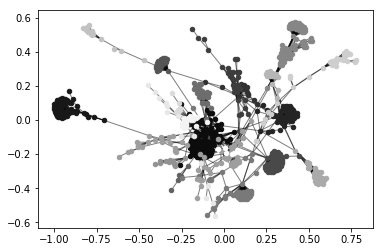

In [44]:
#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(graph_first)
count = 0.
for com in set(partition.values()) :
    print(com)
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(graph_first, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(graph_first, pos, alpha=0.5)
plt.show()

In [40]:
partition = community.best_partition(graph_all)
partition

{'U27476': 0,
 'U4665': 0,
 'U1313': 1,
 'U8804': 2,
 'U14078': 3,
 'U9628': 4,
 'U9721': 4,
 'U2649': 0,
 'U27759': 0,
 'U7310': 5,
 'U22859': 6,
 'U1417': 1,
 'U25611': 1,
 'U24095': 7,
 'U3895': 8,
 'U13005': 9,
 'U2620': 0,
 'U5976': 10,
 'U4249': 10,
 'U9140': 11,
 'U16112': 12,
 'U27776': 0,
 'U27708': 0,
 'U15284': 13,
 'U24549': 0,
 'U18514': 14,
 'U15272': 13,
 'U3933': 8,
 'U15946': 15,
 'U25630': 1,
 'U25632': 1,
 'U22031': 9,
 'U11562': 0,
 'U22071': 9,
 'U15292': 13,
 'U7912': 12,
 'U22018': 9,
 'U18925': 12,
 'U7136': 5,
 'U14498': 10,
 'U21990': 9,
 'U3927': 8,
 'U1381': 1,
 'U22087': 9,
 'U27804': 0,
 'U24252': 2,
 'U7355': 9,
 'U12969': 9,
 'U2180': 16,
 'U11815': 16,
 'U4447': 12,
 'U27679': 0,
 'U27582': 0,
 'U27464': 0,
 'U8029': 10,
 'U1075': 1,
 'U24259': 2,
 'U18564': 14,
 'U27283': 0,
 'U11575': 8,
 'U14507': 10,
 'U27477': 0,
 'U25619': 1,
 'U2661': 17,
 'U24143': 2,
 'U8000': 10,
 'U22015': 9,
 'U24152': 2,
 'U11591': 12,
 'U27585': 0,
 'U27498': 0,
 'U9663': 

# of different communities: 21


/home/valeporti/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


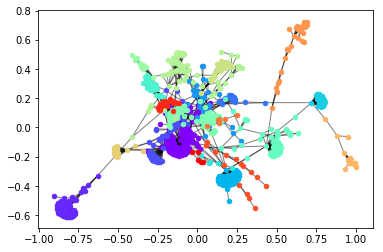

In [102]:
#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(graph_all)
count = 0.
cmap = plt.cm.get_cmap("rainbow", size)
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(graph_all, pos, list_nodes, 
                            node_size = 20,
                            node_color = [cmap(int(count) - 1)], #str(count / size),
                            cmap=plt.cm.rainbow )

print(f'# of different communities: {int(size)}')
nx.draw_networkx_edges(graph_all, pos, alpha=0.5)
plt.show()

In [88]:
print(f'size: {size}')
print(partition.values())

size: 21.0
dict_values([0, 0, 1, 2, 3, 4, 4, 0, 0, 5, 6, 1, 1, 7, 8, 9, 0, 10, 10, 11, 12, 0, 0, 13, 0, 14, 13, 8, 15, 1, 1, 9, 0, 9, 13, 12, 9, 12, 5, 10, 9, 8, 1, 9, 0, 2, 9, 9, 16, 16, 12, 0, 0, 0, 10, 1, 2, 14, 0, 8, 10, 0, 1, 17, 2, 10, 9, 2, 12, 0, 0, 4, 10, 1, 18, 10, 0, 11, 12, 12, 19, 19, 9, 5, 13, 2, 2, 0, 2, 13, 0, 1, 12, 16, 12, 8, 8, 3, 0, 8, 5, 8, 5, 4, 9, 13, 5, 0, 5, 0, 8, 17, 0, 1, 5, 10, 12, 5, 8, 19, 1, 12, 12, 5, 5, 10, 9, 0, 10, 0, 2, 9, 0, 12, 2, 11, 2, 10, 2, 4, 10, 4, 16, 6, 1, 6, 13, 6, 16, 16, 0, 4, 0, 1, 19, 4, 1, 1, 10, 11, 10, 0, 2, 20, 0, 1, 0, 19, 0, 4, 0, 2, 12, 12, 0, 0, 1, 2, 5, 13, 0, 2, 9, 2, 5, 17, 0, 10, 5, 5, 5, 1, 14, 4, 14, 2, 0, 4, 1, 1, 9, 10, 19, 1, 6, 10, 20, 2, 0, 0, 12, 4, 5, 10, 2, 0, 9, 6, 10, 10, 3, 4, 2, 15, 14, 15, 4, 18, 19, 2, 0, 2, 3, 0, 0, 3, 14, 0, 5, 5, 18, 0, 2, 6, 10, 2, 19, 10, 0, 0, 2, 1, 5, 0, 5, 9, 5, 0, 12, 9, 1, 5, 5, 9, 10, 11, 4, 16, 20, 5, 0, 18, 10, 2, 1, 9, 5, 1, 10, 9, 9, 0, 10, 1, 1, 2, 10, 2, 16, 15, 16, 13, 12, 

In [110]:
nx.algorithms.community.centrality(graph_all)

TypeError: 'module' object is not callable

In [90]:
nx.algorithms.community.greedy_modularity_communities(graph_first)

[frozenset({'U11559',
            'U11562',
            'U11563',
            'U11566',
            'U11590',
            'U11591',
            'U11597',
            'U11609',
            'U14657',
            'U14665',
            'U14668',
            'U16078',
            'U16115',
            'U16127',
            'U16134',
            'U16137',
            'U16174',
            'U16177',
            'U16179',
            'U24045',
            'U24046',
            'U24064',
            'U24077',
            'U24080',
            'U24092',
            'U24117',
            'U24184',
            'U24504',
            'U24549',
            'U25559',
            'U25563',
            'U2620',
            'U2649',
            'U2656',
            'U26952',
            'U2696',
            'U2724',
            'U27279',
            'U27283',
            'U27287',
            'U27289',
            'U27300',
            'U27332',
            'U27456',
            'U27463',
            'U2

In [95]:
def list_of_different_attribute_values(d):
    return set([v for values in d.values() for v in values])


In [107]:
nx.assortativity.k_nearest_neighbors(graph_all)

{8: 13.222222222222221,
 10: 14.9375,
 4: 15.263392857142858,
 1: 52.334310850439884,
 5: 15.911627906976744,
 2: 21.376,
 3: 14.513725490196078,
 7: 12.850931677018634,
 16: 11.291666666666666,
 20: 10.225,
 6: 10.568840579710145,
 9: 14.244444444444444,
 17: 8.941176470588236,
 58: 1.7586206896551724,
 11: 10.030303030303031,
 18: 14.055555555555555,
 22: 11.227272727272727,
 13: 19.815384615384616,
 19: 6.2631578947368425,
 14: 11.528571428571428,
 32: 6.53125,
 28: 2.142857142857143,
 46: 4.086956521739131,
 24: 14.916666666666666,
 12: 12.541666666666666,
 37: 8.756756756756756,
 23: 3.782608695652174,
 31: 8.258064516129032,
 122: 4.688524590163935,
 74: 2.054054054054054,
 29: 4.0,
 45: 3.2666666666666666}

In [ ]:
#triangles_in_node = locateTrianglesInNode(G, neighbors, node)
#neighbors_w_triangles = list(set([n for pair in triangles_in_node['triangles_pairs'] for n in pair]))

In [184]:
# Assortativity, it's more probable that influencers are more able to influence
# people with more common things, empathy
# will only include values that exists

def verifyExistanceInList(element, l):
    for v in l:
        # prevent "errors of hand"
        v1 = ''.join(v.lower().split(' ')) 
        v2 = ''.join(element.lower().split(' ')) #
        if (v1 == v2): 
            return True
    return False

def assortativityMark(G, attributes, nodes_to_analyse):
    assortativity_marked_list = []
    assortativity_dict = {}
    for node in nodes_to_analyse:
        neighbors = [n for n in G.neighbors(node)]
        # Obtain Connections
        connections = {}
        total_connections = total_att_vals = 0
        att_assortativity = { att: 0 for att in attributes }
        for neigh in neighbors:#neighbors_w_triangles
            relationships = getPairRelationship(node, neigh, G, attributes)
            local_connections = local_att_vals = 0
            for att, vals in relationships.items():
                total_att_vals += len(vals)
                local_att_vals += len(vals)
                if att not in connections: connections[att] = []
                for v in vals:
                    if not verifyExistanceInList(v, connections[att]): 
                        connections[att].append(v)
                        total_connections += 1
                        local_connections += 1
            # Evaluate nighborhood connections, to get the most common attribute                      
            att_assortativity[att] += local_connections / len(vals) if len(vals) > 0 else 0
        # Evaluate node connections
        assortativity = total_connections / total_att_vals if total_att_vals > 0 else 0
        assortativity_marked_list.append({
            'node': node,
            'assortativity_mark': assortativity,
            'main_att': max(zip(att_assortativity.values(), att_assortativity.keys()))
        })
        assortativity_dict[node] = assortativity

    return { 
        'assortativity_marked_list':  assortativity_marked_list,
        'assortativity_dict': assortativity_dict
    }

assortativity_info = assortativityMark(graph_first, possible_attributes, nodes_with_triangles)
ordered_assorted_list = sorted(assortativity_info['assortativity_marked_list'], 
                               key=itemgetter('assortativity_mark'), reverse=True)
pp.pprint(ordered_assorted_list)

[{'assortativity_mark': 1.0, 'main_att': (2.0, 'employer'), 'node': 'U9140'},
 {'assortativity_mark': 1.0, 'main_att': (1.0, 'location'), 'node': 'U14015'},
 {'assortativity_mark': 1.0, 'main_att': (1.0, 'location'), 'node': 'U15329'},
 {'assortativity_mark': 1.0, 'main_att': (1.0, 'college'), 'node': 'U16132'},
 {'assortativity_mark': 1.0, 'main_att': (1.0, 'employer'), 'node': 'U27636'},
 {'assortativity_mark': 1.0, 'main_att': (1.0, 'college'), 'node': 'U16204'},
 {'assortativity_mark': 1.0, 'main_att': (1.0, 'employer'), 'node': 'U27742'},
 {'assortativity_mark': 1.0, 'main_att': (2.0, 'employer'), 'node': 'U9141'},
 {'assortativity_mark': 1.0, 'main_att': (2.0, 'employer'), 'node': 'U8768'},
 {'assortativity_mark': 0.6666666666666666,
  'main_att': (1.0, 'location'),
  'node': 'U3933'},
 {'assortativity_mark': 0.6666666666666666,
  'main_att': (1.0, 'employer'),
  'node': 'U15289'},
 {'assortativity_mark': 0.6666666666666666,
  'main_att': (1.0, 'employer'),
  'node': 'U3958'},
 {

In [166]:
closeness_centrality_list = [{'node': node, 'closeness': v} for node, v in nx.closeness_centrality(graph_all).items()]
o_closeness_centrality = sorted(closeness_centrality_list, key=itemgetter('closeness'), reverse=True)
betweenness_centrality_list = [{'node': node, 'betweeness': v} for node, v in nx.betweenness_centrality(graph_all).items()]
o_betweenness_centrality = sorted(betweenness_centrality_list, key=itemgetter('betweeness'), reverse=True)
eigenvector_centrality_list = [{'node': node, 'eigenvector': v} for node, v in nx.eigenvector_centrality(graph_all).items()]
o_eigenvector_centrality = sorted(eigenvector_centrality_list, key=itemgetter('eigenvector'), reverse=True)
degree_centrality = [{'node': key, 'degree': val} for key, val in nx.degree_centrality(graph_all).items()]
o_degree_centrality = sorted(order_arr, key=itemgetter('degree'), reverse=True)

In [211]:
def getListOfDesiredLocations(G, term):
    places = []
    for node in G.nodes:
        node_att = G.nodes[node]
        location = node_att['location'][0]
        if term in location.lower():
            if location not in places: places.append(location)
    return places

def normalizeList(o_l, key):
    n_l = o_l[:]
    max_val = n_l[0][key]
    min_val = n_l[-1][key]
    norm_val = max_val - min_val
    #print(f'max:{max_val}, min:{ min_val}, norm: { norm_val}')
    for e in n_l:
        val = e[key] - min_val
        e[key] = val / norm_val
    return n_l

def getCentralityMeasures(G):
    
    deg_c = nx.degree_centrality(G)
    eig_c = nx.eigenvector_centrality(G)
    btw_c = nx.betweenness_centrality(G)
    cls_c = nx.closeness_centrality(G)
    
    c_c_list = [{'node': node, 'closeness': v} for node, v in cls_c.items()]
    o_c_c = sorted(c_c_list, key=itemgetter('closeness'), reverse=True)
    b_c_list = [{'node': node, 'betweeness': v} for node, v in btw_c.items()]
    o_b_c = sorted(b_c_list, key=itemgetter('betweeness'), reverse=True)
    e_c_list = [{'node': node, 'eigenvector': v} for node, v in eig_c.items()]
    o_e_c = sorted(eigenvector_centrality_list, key=itemgetter('eigenvector'), reverse=True)
    d_c_l = [{'node': key, 'degree': val} for key, val in deg_c.items()]
    o_d_c = sorted(d_c_l, key=itemgetter('degree'), reverse=True)
    
    return {
        'n_cls': normalizeList(o_c_c, 'closeness'),
        'n_btw': normalizeList(o_b_c, 'betweeness'),
        'n_eig': normalizeList(o_e_c, 'eigenvector'),
        'n_deg': normalizeList(o_d_c, 'degree'),
        'deg_c': deg_c,
        'eig_c': eig_c,
        'btw_c': btw_c,
        'cls_c': cls_c
    }

def getNodesInPlaces(G, places):
    places_dict = {}
    for place in places:
        nodes = nx.get_node_attributes(G, 'location')
        places_dict[place] = []
        for node, vals in nodes.items():
            if verifyExistanceInList(place, vals) and node not in places_dict[place]: 
                places_dict[place].append(node)
    return places_dict

def findDictElementInList(l, key, c):
    for e in l: 
        if e[key] == c: return e
    

bays = getListOfDesiredLocations(graph_all, 'bay')
centrality_measures = getCentralityMeasures(graph_all)
nodes_in_places = getNodesInPlaces(graph_all, bays)

In [215]:
def determineBestNodes(G, places, centrality_measures, assortativity_measures, 
                       nodes_in_places, nodes_to_choose):
    
    n_cls = centrality_measures['n_cls']
    n_btw = centrality_measures['n_btw']
    n_eig = centrality_measures['n_eig']
    n_deg = centrality_measures['n_deg']
    deg_c = centrality_measures['deg_c']
    eig_c = centrality_measures['eig_c']
    btw_c = centrality_measures['btw_c']
    cls_c = centrality_measures['cls_c']
    ass_m = assortativity_measures['assortativity_dict']
    
    final_marks = []
    for elem in n_deg:
        node = elem['node']
        # avoid a zero multiplication that would discard completely the result, so better sum
        # increase values for assortativity * 2
        deg_val = findDictElementInList(n_deg, 'node', node)['degree']
        eig_val = findDictElementInList(n_eig, 'node', node)['eigenvector']
        btw_val = findDictElementInList(n_btw, 'node', node)['betweeness']
        cls_val = findDictElementInList(n_cls, 'node', node)['closeness']
        ass_val = ass_m[node] if node in ass_m else 0
        sum_measures = (cls_val + btw_val + eig_val + deg_val) + (ass_val) * 2
        final_marks.append({ 'node': node, 'mark': sum_measures})
        #print(f'node: {node}, deg/eig/btw/cls: {deg_c[node]}|{eig_c[node]}|{btw_c[node]}|{cls_c[node]}')
    
    final_marks = sorted(final_marks, key=itemgetter('mark'), reverse=True)
    # Get the final ones (nodes_in_places)
    proposal_nodes_in_places = {}
    for place, p_nodes in nodes_in_places.items():
        proposal_nodes_in_places[place] = []
        count = 0
        for e in final_marks:
            node = e['node']
            if node in p_nodes: 
                ass_val = ass_m[node] if node in ass_m else 0
                proposal_nodes_in_places[place].append(node); count += 1;
                print(f'node: {node}, deg|eig|btw|cls: {deg_c[node]}|{eig_c[node]}|{btw_c[node]}|{cls_c[node]}|{ass_val}')
            if count > nodes_to_choose: break
        
    print(proposal_nodes_in_places)

determineBestNodes(graph_all, bays, centrality_measures, assortativity_info, nodes_in_places, 5)

node: U2627, deg/eig/btw/cls: 0.006172839506172839|0.052132939642734875|0.028185770964288308|0.2131578947368421|0.5
node: U27602, deg/eig/btw/cls: 0.0024691358024691358|0.051249944226751006|0.0|0.2116540371047818|0.5
node: U27585, deg/eig/btw/cls: 0.003703703703703704|0.05182507338179813|0.0|0.20700230002555584|0.5
node: U8670, deg/eig/btw/cls: 0.056790123456790124|0.011920889385545143|0.1717989971049202|0.2162883845126836|0.10344827586206896
node: U4568, deg/eig/btw/cls: 0.01728395061728395|0.09534485924225651|0.12609941543882514|0.23189235614085313|0.1
node: U24045, deg/eig/btw/cls: 0.02962962962962963|0.22040575754968939|0.028083250197991225|0.22810475922275417|0.05172413793103448
{'san francisco bay area': ['U2627', 'U27602', 'U27585', 'U8670', 'U4568', 'U24045']}
